In [3]:
using Images
using ImageView
using Gadfly
using DataFrames

# Uniformly generating unitary operations with fixed average fidelity

## Motivation

One may want to generate noisy operations with fixed average fidelity. The average fidelity is simply defined by the average overlap between the input and the output of a given noise channel $\Lambda$:

\begin{equation}
F_{\text{ave}}(\Lambda):= \int d\phi ~Tr~[|\phi\rangle \langle \phi| \Lambda(\phi)]
\end{equation}

In the Pauli-Liouville superoperator picture, the channel is represented as 

\begin{equation}
{\bf{\Lambda}_{ij}}=\text{Tr}[P_i \Lambda(P_j)]~,
\end{equation}

where $P_i$ are the Pauli operators. For a channel acting on a d-dimensional Hilbert space, the average fidelity can easily be extracted, given the trace of the Pauli-Liouville matrix:

\begin{equation}
F_{\text{ave}}(\Lambda)= \frac{\text{Tr}[{\bf{\Lambda}}]+d}{d^2+d}~.
\end{equation}

If the channel is unitary (i.e ${\bf{\Lambda}}(\rho)=U\rho U^{\dagger})$, we have that

\begin{align}
\text{Tr}[{\bf{\Lambda}}]= & \text{Tr} \left[\sum_i P_i U P_i U^{\dagger}\right] \\
& = \text{Tr} [U] \cdot \text{Tr} [U^{\dagger}]=|\text{Tr} [U]|^2~.
\end{align}

Hence, if we want to generate unitaries with fixed average fidelity, we must generate eigenvalues (that are roots of unity) that add up to a fixed amplitude. This leads us to the problem of the frogs and the water lilies.

## Problem of frogs and the water lilies

### Statement

Romeo the frog is sitting on a lily pad. He wants to reach Juliet the frog's lily pad, which is a distance $r$ away. Of course, Romeo would like to avoid swimming, because he wants to be graceful in front of his lover. Fortunately, Laurence the trout offers his help, by displacing $n$ lily pads. Romeo can jump from one lily pad to the other, but the lenght of his jumps is contrained to 1 unit of distance.

Question: How do we generate a valid path from all possibilies, uniformly at random?

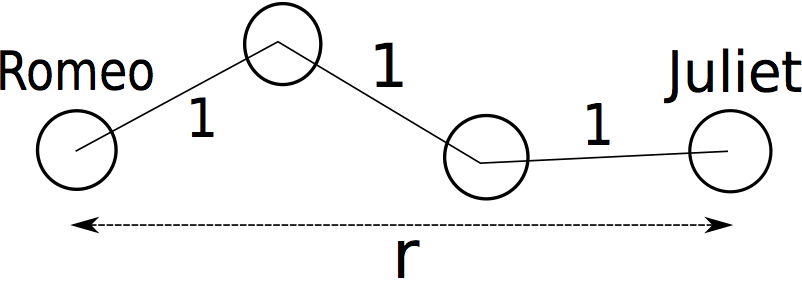

In [50]:
im1=imread("myimage.png")

### Solution

####For $n=1$,
the solution is simple: there are 2 possible paths. Laurence places a lily pad with an angle $\theta=\cos^{-1}(\frac{r}{2})$ (the angle is between the segment linking Romeo and Juliet pads, and the segment linking Romeo and the first lily pad displaced by Laurence). There are 2 possible angles (determined by a fair coin flip).

#### n=2:


On his second jump, Romeo must land on a lily pad which is exactly one distance unit from Juliet's lily pad. He has to jump twice to get on one point of that unit circle. The maximal distance that he can span in $2$ jumps is $2$. The arc contained within the intersection of a circle of radius $2$ centered at the origin, and a unit circle centered at $(r,0)$ consist of all the possible points Romeo can land on in order to reach Juliet on his third jump (see figure ??). Every point on that arc is related with 2 paths ($n=1$ solution), and hence is equi-probable. The protocol is then 

1) Pick a uniformly distributed random angle from $[-\cos^{-1}(\frac{r^2-3}{2r}),\cos^{-1}(\frac{r^2-3}{2r})]$, which determines the location of a lily pad on the arc.

2) Use the solution for $n=1$ to get to that lily pad.


#### n=3:

We sould like to use the same trick as in $n=2$. On his third jump, Romeo must land on a lily pad which is exactly one distance unit from Juliet's lily pad. The maximal distance that he can span is $3$. The arc contained within the intersection of a circle of radius $3$ located at the origin, and a unit circle located at $(r,0)$ consist of all the possible points Romeo can land on in order to reach Juliet on his third jump (see figure ??). However, the points on the arc are not equi-probable anymore, since they each correspond to a different number of paths. For each point (located at a distance $r'$ from the origin), we have to solve a $n=2$ problem, which provides a number of paths that is proportional to the arc lenght $l=2\cos^{-1}(\frac{r'^2-3}{2r'})$.

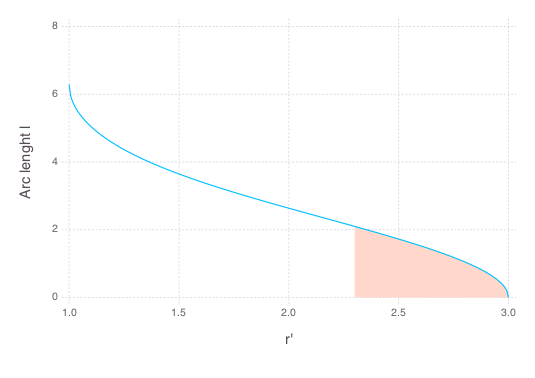

In [4]:
function arclength(x)
        return 2*acos((x.^2-3)./(2.*x))
end    
xs = 2.3:0.01:3.  # Allowed interval for r'
arc_reg = DataFrame(
    x=xs,
    y=arclength(xs),
    ymin=0.*xs,
    ymax=arclength(xs)
)
plot(layer(arclength,1.,3),
layer(arc_reg, x=:x, y=:y, ymin=:ymin, ymax=:ymax,Theme(default_color=color("red")), Geom.ribbon),
Guide.ylabel("Arc lenght l"),
Guide.xlabel("r'"))

The possible values of $r'$ are between $r-1$ and $3$. We chose $r=3.3$ in the figure above, in order to show the allowed domain of $r'$ (which is under the red region). The strategy, given a fixed $r$, is to :

1) Pick $r'$ using the probability density function $\rho(r')=\frac{2\cos^{-1}(\frac{r'^2-3}{2r'})}{\int_{r-1}^32\cos^{-1}(\frac{s^2-3}{2s})ds}$ (defined from $r-1$ to $\min \{3, r+1\}$)

2) Associate it with a point on the unit arc (there will be 2 possibilities, pick one with a fair coin flip).

3) Use the solution for $n=2$.

#### n>=4 :

We can proceed iteratively in order to get the following protocol:

1) Pick $r'$ using the probability density function $\rho(r')=\frac{1}{N}\int_{s_{n-3}=r'-1}^{s_{n-3}=n-1} \int_{s_{n-4}=s_{n-3}-1}^{s_{n-4}=n-2}\cdots \int_{s_1=s_2-1}^{s_1=3} 2\cos^{-1}(\frac{s_{1}^2-3}{2s_{1}})ds_{1}\cdots ds_{n-3}$

where $N=\int_{r'=r-1}^n\int_{s_{n-3}=r'-1}^{s_{n-3}=n-1} \int_{s_{n-4}=s_{n-3}-1}^{s_{n-4}=n-2}\cdots \int_{s_1=s_2-1}^{s_1=3} 2\cos^{-1}(\frac{s_{1}^2-3}{2s_{1}})ds_{1}\cdots ds_{n-3}dr'$

*** The upper bounds in the integral are rigourously $\min \{n-i, s_{n-i-1}+1\}$.

2) Use the solution for $n-1$

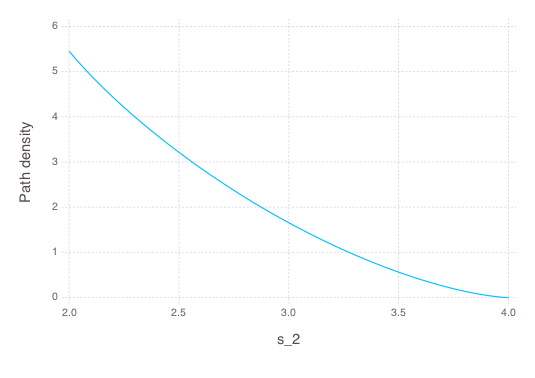

In [5]:
# Compute the first (non-normalized) function with trapezes' method
delta=0.001;
xs=3.:-delta:1.;
f1=zeros(length(xs));
for i=1:length(xs)-1
    f1[i+1]=f1[i]+(arclength(xs[i+1])+arclength(xs[i])).*delta./2;
end
plot(x=xs+1, y=f1, Geom.line, Guide.ylabel("Path density"),
Guide.xlabel("s_2"))

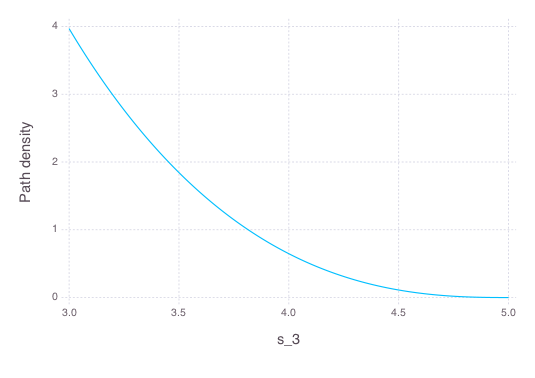

In [6]:
# Compute the second (non-normalized) function with trapezes' method
delta=0.001;
xs=3.:-delta:1.;
f2=zeros(length(xs));
for i=1:length(xs)-1
    f2[i+1]=f2[i]+(f1[i+1]+f1[i]).*delta./2;
end
plot(x=xs+2, y=f2, Geom.line, Guide.ylabel("Path density"),
Guide.xlabel("s_3"))

### Summary:

I would like to present a simple example to ensure the protocol's clarity. Let $n=5$, and $r=5.8$. 

1) We first pick a value $r_1$, with respect to the probability density defined between $4.8$ and $5$.

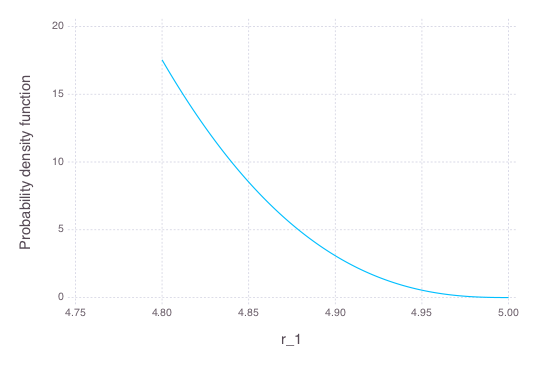

In [7]:
# Compute the second (non-normalized) function with trapezes' method
delta=0.001;
xs=3.:-delta:2.8;
f2=zeros(length(xs));
for i=1:length(xs)-1
    f2[i+1]=f2[i]+(f1[i+1]+f1[i]).*delta./2;
end
# Computing the normalization constant
N=0.;
for i=1:length(f2)-1
    N=N+(f2[i+1]+f2[i]).*delta./2;
end
plot(x=xs+2, y=f2./N, Geom.line, Guide.ylabel("Probability density function"),
Guide.xlabel("r_1"))

Say that we got $r_1=4.85$. 

2) We pick a value $r_2$, with respect to the probability density defined between $3.85$ and $4$.

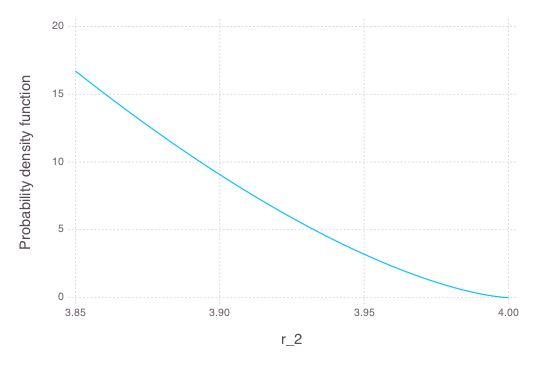

In [8]:
# Compute the first (non-normalized) function with trapezes' method
delta=0.001;
xs=3.:-delta:2.85;
f1=zeros(length(xs));
for i=1:length(xs)-1
    f1[i+1]=f1[i]+(arclength(xs[i+1])+arclength(xs[i])).*delta./2;
end
# Computing the normalization constant
N=0.;
for i=1:length(f1)-1
    N=N+(f1[i+1]+f1[i]).*delta./2;
end
plot(x=xs+1, y=f1./N, Geom.line, Guide.ylabel("Probability density function"),
Guide.xlabel("r_2"))

Say that we got $r_2=3.95$. 

3) We pick a value $r_3$, with respect to the probability density defined between $2.95$ and $3$.

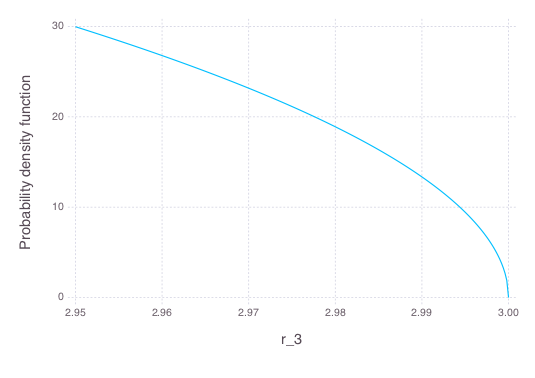

In [9]:
# Normalizing constant
N=0;
delta=0.0001;
for xss=2.95:delta:3.
    N=N+(arclength(xss-delta)+arclength(xss)).*delta./2;
end
function arclengthnorm(x)
    return arclength(x)./N;
end
plot(arclengthnorm, 2.95, 3.,Guide.ylabel("Probability density function"),
Guide.xlabel("r_3"))

Say we picked $r_3=2.96$. 

4) Pick an angle $\theta$ from the uniform distribution:

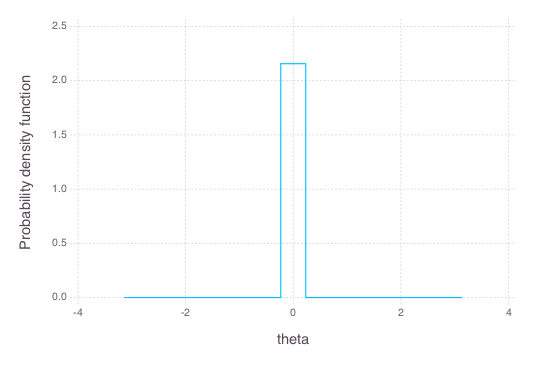

In [10]:
anglemin=-acos((2.96^2-3.)/(2*2.96));
anglemax=acos((2.96^2-3.)/(2*2.96));
N=1./(anglemax-anglemin);
xss=[-pi, anglemin, anglemin, anglemax, anglemax, pi];
yss=[0,0,N,N,0,0];
plot(x=xss,y=yss, Geom.line,Guide.ylabel("Probability density function"),
Guide.xlabel("theta"))


Say we got $\theta=0.1$. We still have $16$ paths left, since we each $r_i$ we have 2 possible paths ($2^3=8$ paths), and we also have 2 paths in order to reach Romeo's lily pad. In order to fix a single path, we simply flip $4$ fair coins, and we choose the associated path.

## How is this problem related with fixed fidelity's unitaries?

We ultimately want to create a unitary operation with a trace having a fixed amplitude ($|\text{Tr}U|=c$). We can respresent $U$ as

$U=V D V^{\dagger}$ ,

where $D$ is diagonal, and each eigenvalue is a root of unity, $\lambda_j=e^{i \theta_j}$. We want the amplitude of the sum to be fixed: $|\sum_j e^{i \theta_j}|=c$. Interpreting these eienvalues as unit long jumps in the complex plane, and using the global phase invariance, we find back the problem of the frogs and the water lilies. Each path correspond to a value of $D$. Once we generate $D$, we can generate $V$ with respect to the Haar measure (which is not too hard, see Toby Cubitt's code).